## Importações

In [1]:
import os
import pandas as pd
import numpy as np
import requests
import zipfile
import io

In [2]:
# Obtém o diretório de trabalho atual
current_dir = os.getcwd()

### Baixando Dataset

In [3]:
# URL do arquivo ZIP
url = "https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip"

# Nome do arquivo ZIP
filename = "online+retail+ii.zip"

# Caminho de destino para salvar e extrair o arquivo ZIP
destination_path = os.path.join(os.getcwd(), "raw-data")

# Verifica se o arquivo já existe no destino
file_path = os.path.join(destination_path, filename)
if os.path.exists(file_path):
    print("O arquivo já existe no destino. Nenhuma cópia necessária.")
else:
    # Realiza o download do arquivo ZIP
    print("Baixando o arquivo ZIP...")
    response = requests.get(url)
    response.raise_for_status()

    # Salva o conteúdo do arquivo ZIP em disco
    with open(file_path, "wb") as file:
        file.write(response.content)

    # Extrai o conteúdo do arquivo ZIP
    print("Extraindo o arquivo ZIP...")
    with zipfile.ZipFile(file_path, "r") as zip_ref:
        zip_ref.extractall(destination_path)

    print("Extração concluída.")


O arquivo já existe no destino. Nenhuma cópia necessária.


### Importando o arquivo:

In [4]:
# Caminho para o arquivo Excel
filepath =  current_dir + "/raw-data/online_retail_II.xlsx"

# Lendo o arquivo Excel usando o Pandas
df = pd.read_excel(filepath)

## Informações dos atributos:


**InvoiceNo**: Número da fatura. (Nominal) Um número inteiro de 6 dígitos atribuído exclusivamente a cada transação. Se o código começar com a letra 'c', indica um cancelamento  
**StockCode**: Código do produto (item). (Nominal) Um número inteiro de 5 dígitos atribuído exclusivamente a cada produto distinto.  
**Description**: Descrição do produto (item). (Nominal)  
**Quantity**: Quantidade de cada produto (item) por transação. (Numérico)  
**InvoiceDate**: Data e hora da fatura. (Numérico) O dia e a hora em que a transação foi gerada.  
**UnitPrice**: Preço unitário. (Numérico) Preço do produto por unidade em libras esterlinas (£).  
**CustomerID**: Número do cliente. (Nominal) Um número inteiro de 5 dígitos atribuído exclusivamente a cada cliente.  
**Country**: País. (Nominal) O nome do país onde o cliente reside.  

## Analise Exploratória

In [5]:
print('Qtd Países:',len(df['Country'].unique()))
print('Qtd Clients:', len(df['Customer ID'].unique()))
print('Qtd Produtos:', len(df['StockCode'].unique()))

Qtd Países: 40
Qtd Clients: 4384
Qtd Produtos: 4632


### Histograma Preço

<Axes: >

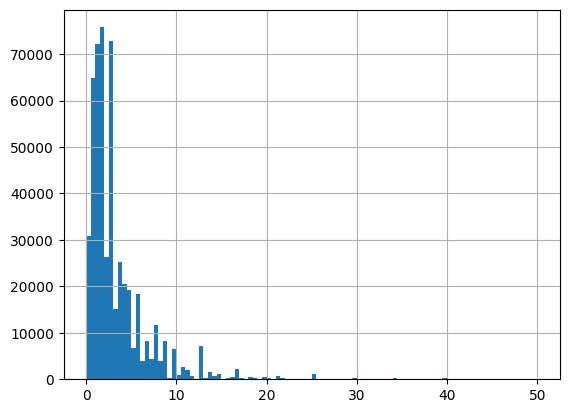

In [6]:
df.loc[(df['Price'] > 0) & (df['Price']<50)]['Price'].hist(bins=100)

## Limpando Dados

#### Retirando Cancelamentos e Compras Correspondentes

In [7]:
# Função para capturar todos os Invoices que se tratam de um cancelamento
def get_cancelled_invoices(df):
    # Converter NaNs e outros tipos para string antes de aplicar o filtro
    df['Invoice'] = df['Invoice'].astype(str)
    cancelled_invoices = df[df['Invoice'].str.startswith('C')]['Invoice'].tolist()
    original_invoices = [invoice[1:] for invoice in cancelled_invoices]
    return cancelled_invoices + original_invoices

# Função para remover todas as linhas de cancelamento e a compra correspondente a esse cancelamento
def remove_cancelled_invoices(df, cancelled_invoices):
    # Converter NaNs e outros tipos para string antes de aplicar o filtro
    df['Invoice'] = df['Invoice'].astype(str)
    return df[~df['Invoice'].isin(cancelled_invoices)]

In [8]:
cancelled_invoices = get_cancelled_invoices(df)
df_clean = remove_cancelled_invoices(df, cancelled_invoices)

df_clean.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


#### Retirando os preços muito grandes

In [9]:
df_clean = df_clean[(df_clean['Price'] < 50) & (df_clean['Price'] > 0)]

<Axes: >

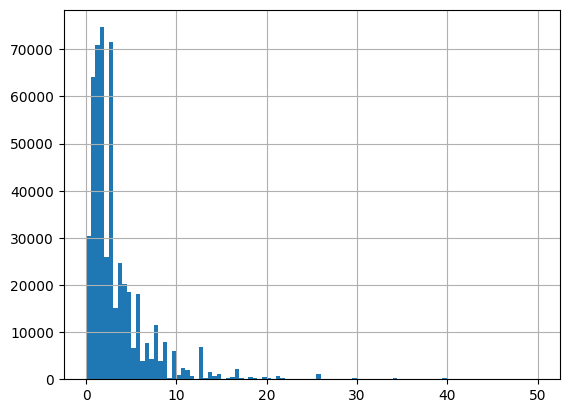

In [10]:
df_clean['Price'].hist(bins=100)

In [11]:
df_clean.isna().sum()

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    103200
Country             0
dtype: int64

In [13]:
df_clean = df_clean.dropna()
df_clean.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

#### Consertando os tipos de dados

In [19]:
df_clean['Costumer ID'] = df_clean['Customer ID'].astype(object)
df_clean.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
Costumer ID            object
dtype: object

array([[<Axes: title={'center': 'Quantity'}>,
        <Axes: title={'center': 'InvoiceDate'}>],
       [<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Customer ID'}>]], dtype=object)

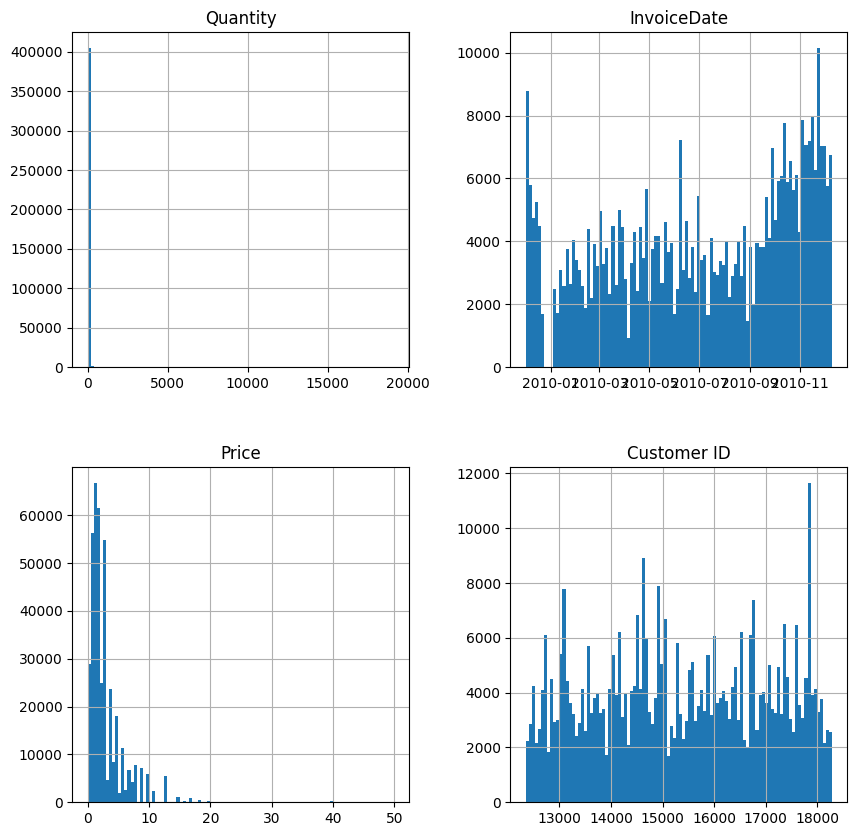

In [20]:
df_clean.hist(figsize=(10,10), bins=100)

#### Retirando os valores de quantidade maior que 100

array([[<Axes: title={'center': 'Quantity'}>,
        <Axes: title={'center': 'InvoiceDate'}>],
       [<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Customer ID'}>]], dtype=object)

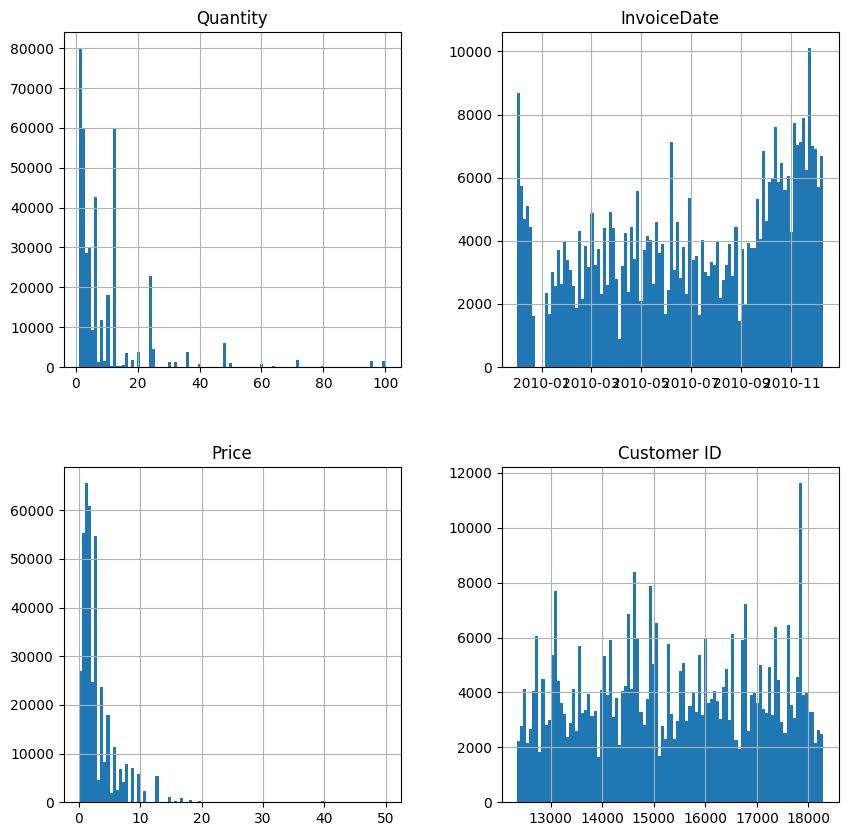

In [35]:
df_clean.loc[df_clean['Quantity'] <=100].hist(figsize=(10,10), bins=100)

In [36]:
df_clean = df_clean[df_clean['Quantity'] < 100]

In [38]:
df_clean[['Costumer ID', 'Country', 'Invoice', 'StockCode','Quantity', 'Price', 'InvoiceDate']].to_csv('data.csv', index=False)